# 1. Niveles Lingüísticos

## Tarea 1: Niveles del lenguaje

### FECHA DE ENTREGA: 16 de Febrero 2025 at 11:59pm

### Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*
  - Reutiliza el sistema de búsqueda visto en clase y mejoralo con esta funcionalidad

In [4]:
# Bibliotecas
import requests as r
from pprint import pprint as pp
from rich import print as rprint
from rich.columns import Columns 
from rich.panel import Panel
from rich.text import Text
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#### Obtención y manipulación

In [5]:
import http

def download_ipa_corpus(iso_lang: str) -> str:
    """Get ipa-dict file from Github

    Parameters:
    -----------
    iso_lang:
        Language as iso code

    Results:
    --------
    dict:
        Dictionary with words as keys and phonetic representation
        as values for a given lang code
    """
    print(f"Downloading {iso_lang}", end="::")
    response = r.get(IPA_URL.format(lang=iso_lang))
    status_code = response.status_code
    print(f"status={status_code}")
    if status_code != http.HTTPStatus.OK:
        print(f"ERROR on {iso_lang} :(")
        return ""
    return response.text

In [6]:
def parse_response(response: str) -> dict:
    """Parse text response from ipa-dict to python dict

    Each row have the format:
    [WORD][TAB]/[IPA]/(, /[IPA]/)?

    Parameters
    ----------
    response: str
        ipa-dict raw text

    Returns
    -------
    dict:
        A dictionary with the word as key and the phonetic
        representations as value
    """
    ipa_list = response.rstrip().split("\n")
    result = {}
    for item in ipa_list:
        if item == '':
            continue
        item_list = item.split("\t")
        result[item_list[0]] = item_list[1]
    return result

In [7]:
def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """Search for a word in an IPA phonetics dict

    Given a word this function return the IPA transcriptions

    Parameters:
    -----------
    word: str
        A word to search in the dataset
    dataset: dict
        A dataset for a given language code

    Returns
    -------
    list[str]:
        List with posible transcriptions if any,
        else an empty list
    """
    return dataset.get(word.lower(), "").split(", ")

#### Obteniendo todos los datos

In [8]:
IPA_URL = "https://raw.githubusercontent.com/open-dict-data/ipa-dict/master/data/{lang}.txt"

In [9]:
lang_codes = {
    "ar": "Arabic (Modern Standard)",
    "de": "German",
    "en_UK": "English (Received Pronunciation)",
    "en_US": "English (General American)",
    "eo": "Esperanto",
    "es_ES": "Spanish (Spain)",
    "es_MX": "Spanish (Mexico)",
    "fa": "Persian",
    "fi": "Finnish",
    "fr_FR": "French (France)",
    "fr_QC": "French (Québec)",
    "is": "Icelandic",
    "ja": "Japanese",
    "jam": "Jamaican Creole",
    "km": "Khmer",
    "ko": "Korean",
    "ma": "Malay (Malaysian and Indonesian)",
    "nb": "Norwegian Bokmål",
    "nl": "Dutch",
    "or": "Odia",
    "ro": "Romanian",
    "sv": "Swedish",
    "sw": "Swahili",
    "tts": "Isan",
    "vi_C": "Vietnamese (Central)",
    "vi_N": "Vietnamese (Northern)",
    "vi_S": "Vietnamese (Southern)",
    "yue": "Cantonese",
    "zh_hans": "Mandarin (Simplified)",
    "zh_hant": "Mandarin (Traditional)"
}
iso_lang_codes = list(lang_codes.keys())

In [10]:
def get_corpora() -> dict:
    """Download corpora from ipa-dict github

    Given a list of iso lang codes download available datasets.

    Returns
    -------
    dict
        Lang codes as keys and dictionary with words-transcriptions
        as values
    """
    return {
        code: parse_response(download_ipa_corpus(code))
         for code in iso_lang_codes
        }

In [11]:
data = get_corpora()

#### Sistema de búsqueda  

In [12]:
from Levenshtein import distance as levenshtein_distance

def buscar_palabras_similares(palabra, dicc , top_n=3):
    """
    Encuentra las n palabras más similares en el diccionario usando la distancia de Levenshtein.
    """
    palabras_ordenadas = sorted(dicc.keys(), key=lambda x: levenshtein_distance(palabra, x))[:top_n]
    return palabras_ordenadas

In [13]:
def get_formated_string(code: str, name: str) -> str:
    """
    Devuelve una cadena formateada con negritas y color amarillo para su uso con `rich.print`.

    Args:
        code (str): Código del idioma.
        name (str): Nombre del idioma.

    Returns:
        str: String formateado con etiquetas de `rich`.
    """
    return f"[bold]{name.strip()}[/bold]\n[yellow]{code.strip()}"

In [14]:
def process_query(query: str, sub_dataset: Dict[str, List[str]]) -> None:
    """
    Procesa una consulta de palabra, buscando su transcripción fonética en el diccionario
    y mostrando sugerencias si no se encuentra.

    Args:
        query (str): Palabra ingresada por el usuario.
        sub_dataset (Dict[str, List[str]]): Diccionario de palabras y transcripciones fonéticas.
    """
    query = query.lower()  # Convertir la palabra a minúsculas
    
    if query in sub_dataset:
        results = get_ipa_transcriptions(query, sub_dataset)
        rprint(f"[bold green]{query}[/bold green] | {', '.join(results)}")  # Mostrar resultado
    else:
        rprint(f"[bold red]❌ La palabra '{query}' no se encuentra en el diccionario.[/bold red] 😞")
        
        # Buscar palabras similares
        palabras_similares = buscar_palabras_similares(query, sub_dataset)
        
        if palabras_similares:
            rprint("[bold blue]Quizá quisiste decir:[/bold blue] 👇")
            for palabra in palabras_similares:
                results = get_ipa_transcriptions(palabra, sub_dataset)
                rprint(f"  🔹 [bold cyan]{palabra}[/bold cyan] | {', '.join(results)}")
        else:
            rprint("[bold yellow]⚠️ No se encontraron palabras similares.[/bold yellow]")


In [15]:
# Mostrar título de la interfaz
rprint(Panel(Text("📖 Representación fonética de palabras", style="bold", justify="center")))

# Mostrar idiomas disponibles
rendable_langs = [Panel(get_formated_string(code, lang), expand=True) for code, lang in lang_codes.items()]
rprint(Columns(rendable_langs))

# Bucle principal para selección de idioma y procesamiento de palabras
while True:
    lang = input("🌍 Seleccione un idioma (código) ")

    if not lang:
        rprint("👋🏼 [bold yellow]Adiós![/bold yellow]")
        break  # Salir del programa

    # Validar si el idioma ingresado existe en `lang_codes`
    if lang not in lang_codes:
        rprint(f"[bold red]❌ '{lang}' no es un código de idioma válido.[/bold red] Intenta de nuevo.")
        continue

    rprint(f"✅ [bold green]Idioma seleccionado:[/bold green] {lang_codes[lang]}")

    sub_dataset = data.get(lang, {})  # Obtener subconjunto de datos para el idioma
    
    while True:
        query = input(f"  [{lang}] Palabra >> ").strip()
        if not query:
            break  # Salir al menú de selección de idioma
        process_query(query, sub_dataset)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                     📖 Representación fonética de palabras                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Arabic (Modern Standard)   │ │ German                           │ │ English (Received Pronunciation) │
│ ar                         │ │ de                               │ │ en_UK                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ English (General American) │ │ Esperanto                        │ │ Spanish (Spain)                  │
│ en_US                      │ │ eo                               │ │ es_ES                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Spanish (Mexico)           │ │ Persian                          │ │ Finnish                          │
│ es_MX                      │ │ fa                               │ │ fi                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ French (France)            │ │ French (Québec)                  │ │ Icelandic                        │
│ fr_FR                      │ │ fr_QC                            │ │ is                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Japanese                   │ │ Jamaican Creole                  │ │ Khmer                            │
│ ja                         │ │ jam                              │ │ km                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Korean                     │ │ Malay (Malaysian and Indonesian) │ │ Norwegian Bokmål                 │
│ ko                         │ │ ma                               │ │ nb                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Dutch                      │ │ Odia                             │ │ Romanian                         │
│ nl                         │ │ or                               │ │ ro                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Swedish                    │ │ Swahili                          │ │ Isan                             │
│ sv                         │ │ sw                               │ │ tts                              │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Vietnamese (Central)       │ │ Vietnamese (Northern)            │ │ Vietnamese (Southern)            │
│ vi_C                       │ │ vi_N                             │ │ vi_S                             │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Cantonese                  │ │ Mandarin (Simplified)            │ │ Mandarin (Traditional)           │
│ yue     

✅ Idioma seleccionado: Spanish (Mexico)

hola | /ola/

❌ La palabra 'ratillo' no se encuentra en el diccionario. 😞

Quizá quisiste decir: 👇

🔹 gatillo | /gatiʎo/

🔹 hatillo | /atiʎo/

🔹 rabillo | /raβiʎo/

❌ La palabra 'raton' no se encuentra en el diccionario. 😞

Quizá quisiste decir: 👇

🔹 rato | /rato/

🔹 ratón | /raˈton/

🔹 ratona | /ratona/

👋🏼 Adiós!

In [16]:
# Paso 0 : el metodo recibe una palabra y un lang
# paso 1 : Ver si la palabra ya existe en el diccionario del idioma
# Paso 2 : De lo contrario calcular la distancia de cada palabra del dataset del idioma actual 
# Paso 3 : Quedarse con las 3 palabras mas parecidas
# Paso 4 : regresarlas como una lista



### Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 columnas y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - Plot 1: distribución de longitud de palabras
        - Plot 2: distribución de la cuenta de morfemas
        - Plot 3: distribución de categorias (si existe para la lengua)
    - Realice una función que imprima por cada lengua lo siguiente:
        - Total de palabras
        - La longitud de palabra promedio
        - La cuenta de morfemas promedio
        - La categoría más común
    - Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.


#### Corpus: [SIGMORPHON 2022 Shared Task on Morpheme Segmentation](https://github.com/sigmorphon/2022SegmentationST/tree/main)

- Shared task donde se buscaba convertir las palabras en una secuencia de morfemas
- Dividido en dos partes:
    - Segmentación a nivel de palabras (nos enfocaremos en esta)
    - Segmentación a nivel oraciones

#### Track: words

| word class | Description                      | English example (input ==> output)     |
|------------|----------------------------------|----------------------------------------|
| 100        | Inflection only                  | played ==> play @@ed                   |
| 010        | Derivation only                  | player ==> play @@er                   |
| 101        | Inflection and Compound          | wheelbands ==> wheel @@band @@s        |
| 000        | Root words                       | progress ==> progress                  |
| 011        | Derivation and Compound          | tankbuster ==> tank @@bust @@er        |
| 110        | Inflection and Derivation        | urbanizes ==> urban @@ize @@s          |
| 001        | Compound only                    | hotpot ==> hot @@pot                   |
| 111        | Inflection, Derivation, Compound | trackworkers ==> track @@work @@er @@s

#### Métodos para descargar los datos

In [17]:
response = r.get("https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/spa.word.test.gold.tsv")
response.text[:100]

'astronómica\tastronómico @@a\t100\nresignifiques\tresignificar @@es\t100\nimportunamente\timportuno @@mente'

In [18]:
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [19]:
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task

    Con base en el idioma y el track obtiene el nombre de los archivos
    para con información relevante para hacer análisis estadístico.
    Esto es archivos .test y .dev

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y la pista especificados.
    """
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]

In [20]:
def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result

In [21]:
def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append({"words": word, "morph": morphemes, "category": category, "lang": lang})
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df

#### Descargamos los df de cada idioma

In [22]:
def get_all_df(langs):
    dfs = {}
    for lang in langs.keys():
        files = get_track_files(lang)
        raw_lang = get_raw_corpus(files)
        df = raw_corpus_to_dataframe(raw_lang, lang=lang)
        dfs[lang] = df
    return dfs

In [23]:
# Obtenemos los datos de los 8 idiomas en dataframes
data_langs = get_all_df(LANGS)

In [24]:
data_langs["ces"]

,words,morph,category,lang,word_len,morph_count
0,abbé,"[abb, @@é]",NOT_FOUND,ces,4,2
1,absolutno,"[absolut, @@n, @@o]",NOT_FOUND,ces,9,3
2,absolventi,"[ab, @@solv, @@ent, @@i]",NOT_FOUND,ces,10,4
3,abychom,"[a, @@by, @@chom]",NOT_FOUND,ces,7,3
4,achronisticky,"[a, @@chron, @@ist, @@ic, @@k, @@y]",NOT_FOUND,ces,13,6
...,...,...,...,...,...,...
7995,žvanit,"[žvan, @@i, @@t]",NOT_FOUND,ces,6,3
7996,žvastat,"[žvast, @@a, @@t]",NOT_FOUND,ces,7,3
7997,žádnému,"[žádn, @@ému]",NOT_FOUND,ces,7,2
7998,žádáme,"[žád, @@á, @@me]",NOT_FOUND,ces,6,3


In [25]:
# Figura de 8x4 con longitud
def plot_word_length_distribution(data_dict):
    """Genera una figura con subplots para la distribución de la longitud de palabras."""
    languages = list(data_dict.keys())
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, lang in enumerate(languages):
        df = data_dict[lang]
        word_lengths = df['words'].apply(len)
        sns.histplot(word_lengths, bins=20, ax=axes[i], kde=True)
        axes[i].set_title(f"{lang} - Longitud de palabras")
        axes[i].set_xlabel("Número de caracteres")
        axes[i].set_ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

In [26]:
# Figura de 8x4 con morfemas
def plot_morpheme_distribution(data_dict):
    """Genera una figura con subplots para la distribución de la cuenta de morfemas."""
    languages = list(data_dict.keys())

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, lang in enumerate(languages):
        df = data_dict[lang]
        if 'morph_count' in df.columns:
            sns.histplot(df['morph_count'], bins=15, ax=axes[i], kde=True)
            axes[i].set_title(f"{lang} - Cuenta de morfemas")
            axes[i].set_xlabel("Número de morfemas")
            axes[i].set_ylabel("Frecuencia")
        else:
            axes[i].set_visible(False)  # Ocultar si no hay datos

    plt.tight_layout()
    plt.show()

In [27]:
# Figura de 8x4 con categorias
def plot_category_distribution(data_dict):
    """Genera una figura con subplots para la distribución de categorías gramaticales."""
    languages = list(data_dict.keys())

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, lang in enumerate(languages):
        df = data_dict[lang]
        if 'category' in df.columns:
            sns.countplot(y=df['category'], order=df['category'].value_counts().index, ax=axes[i])
            axes[i].set_title(f"{lang} - Categorías gramaticales")
            axes[i].set_xlabel("Frecuencia")
            axes[i].set_ylabel("Categoría")
        else:
            axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

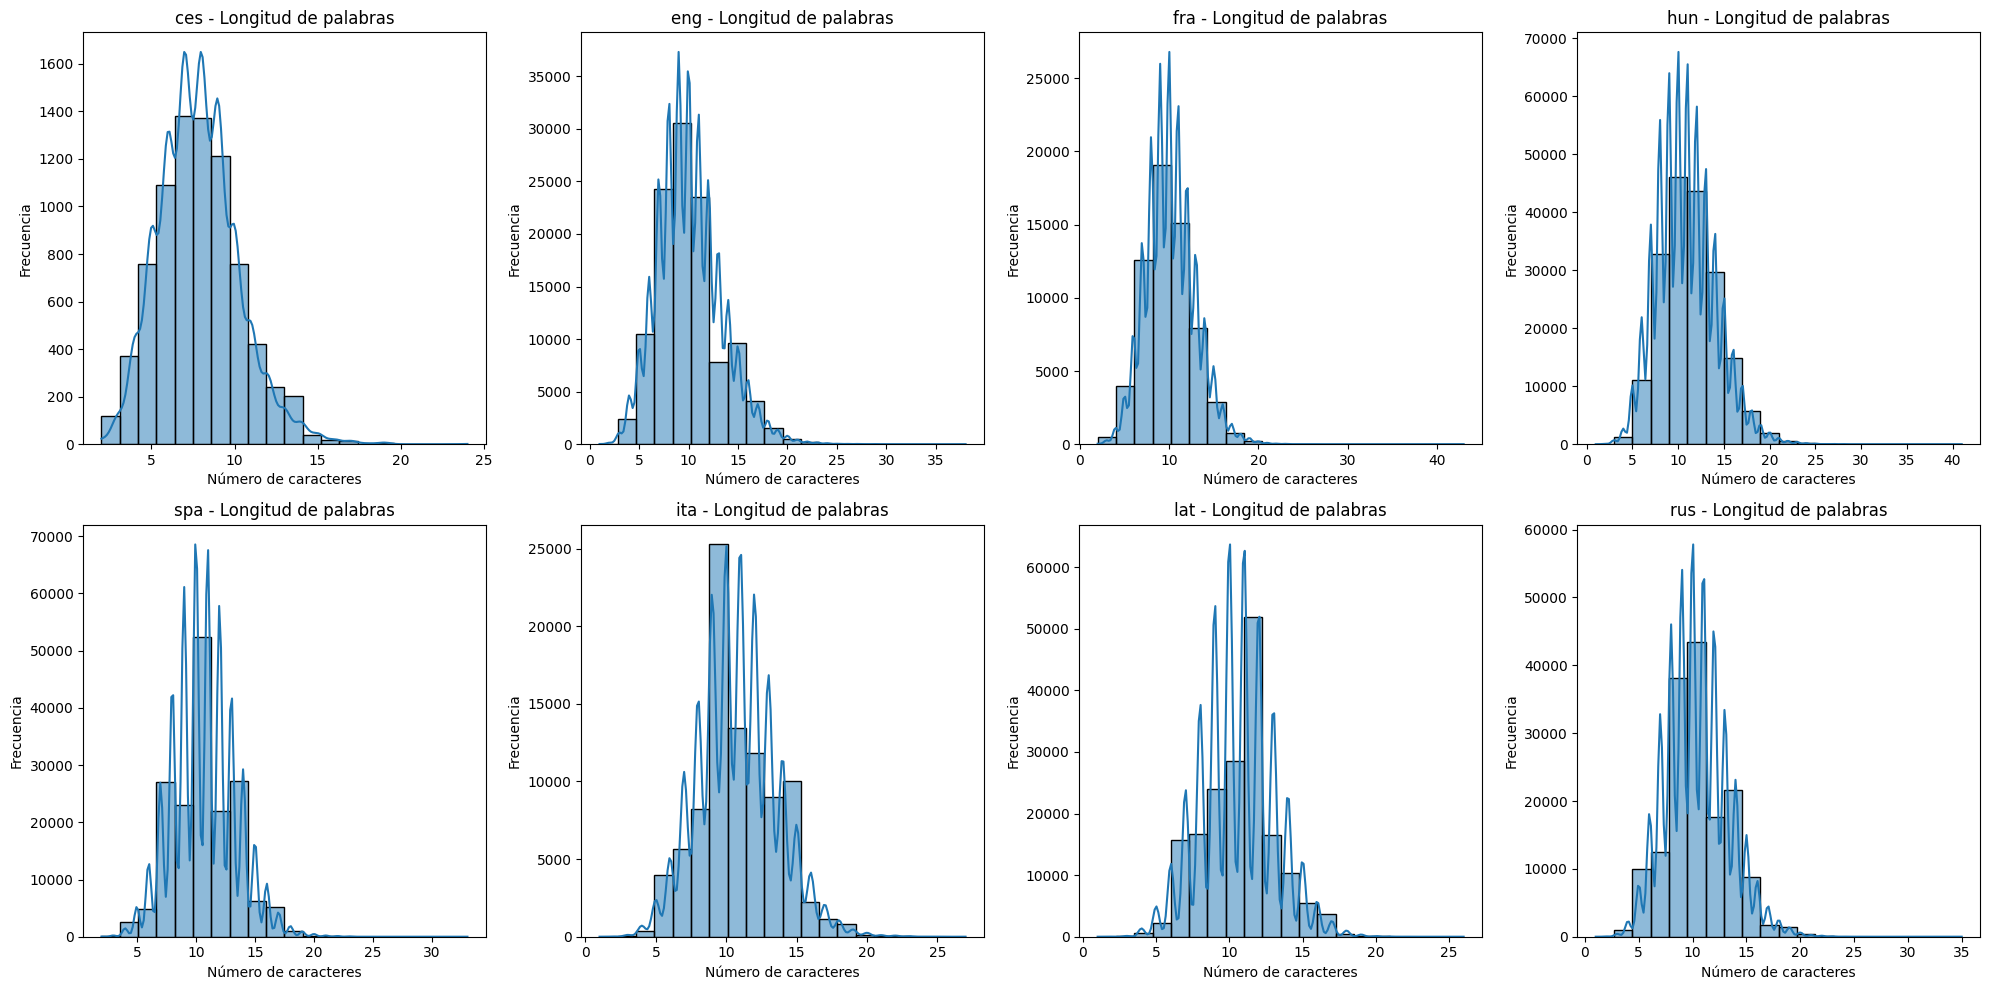

In [28]:
plot_word_length_distribution(data_langs)

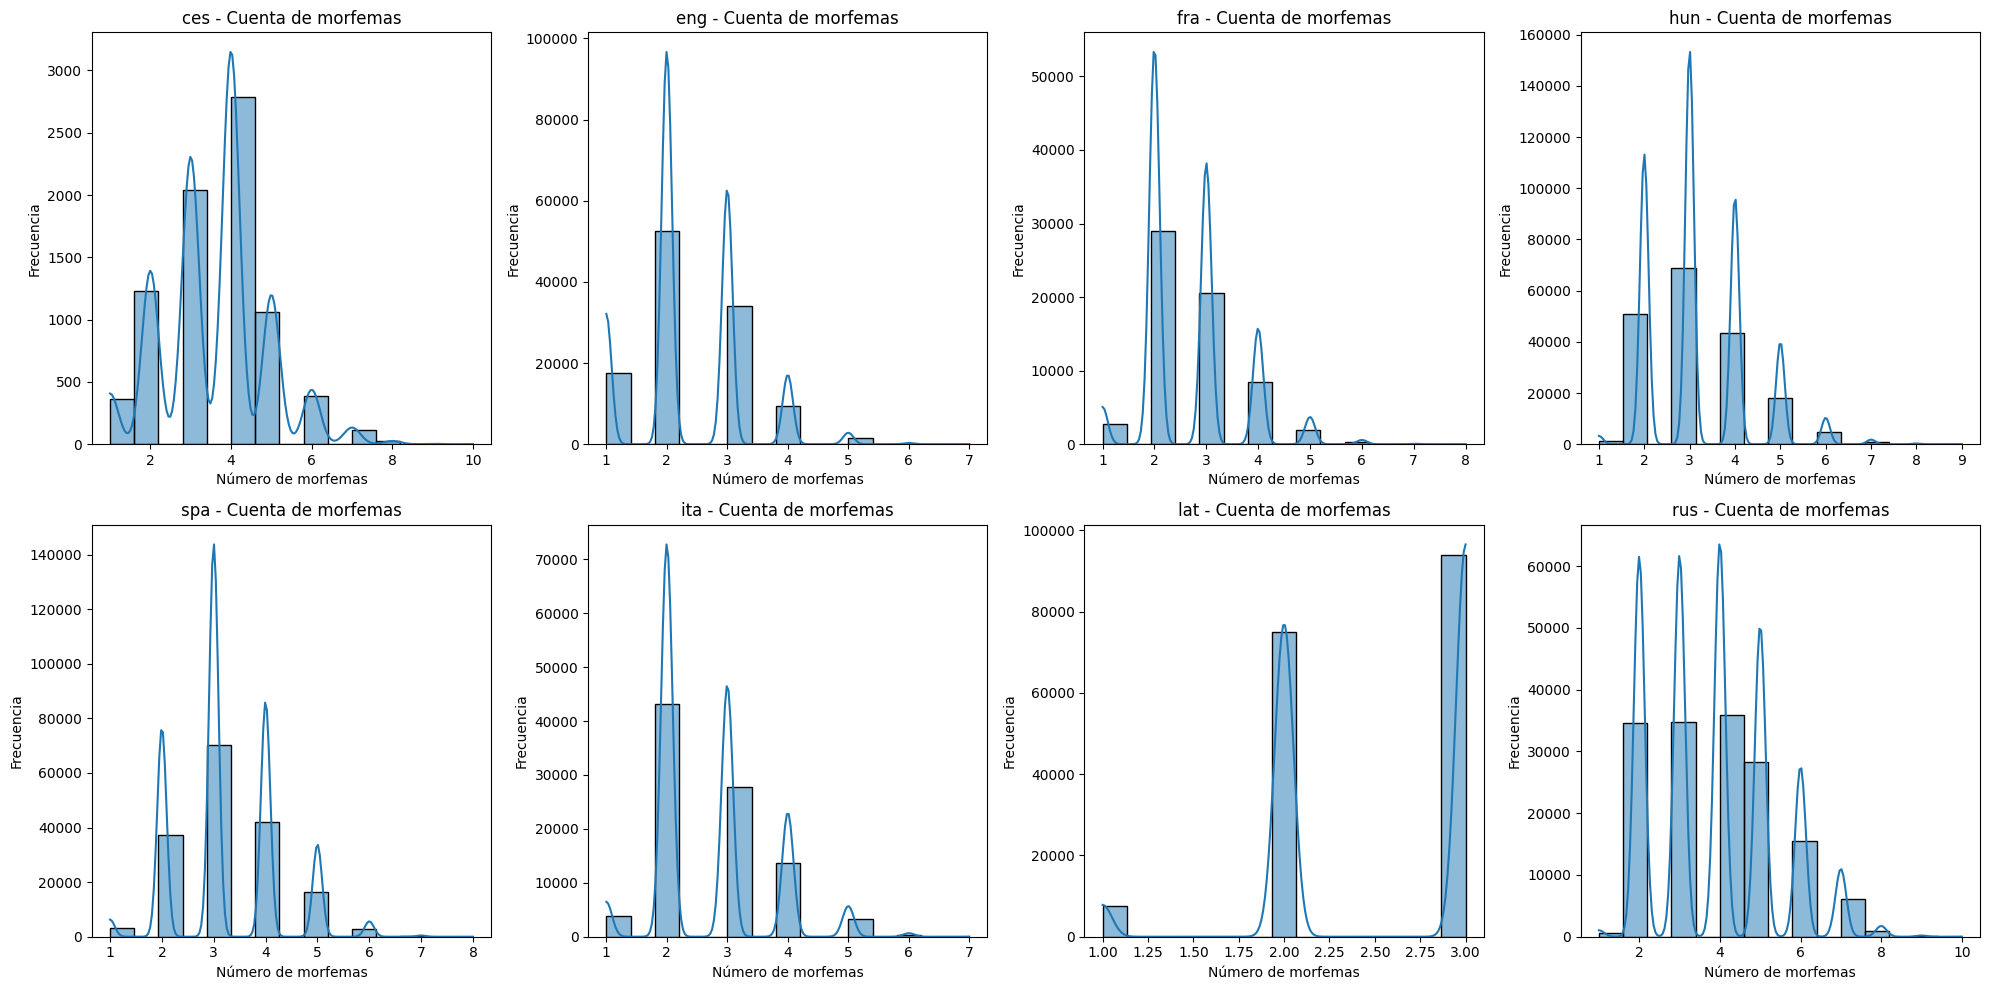

In [29]:
plot_morpheme_distribution(data_langs)

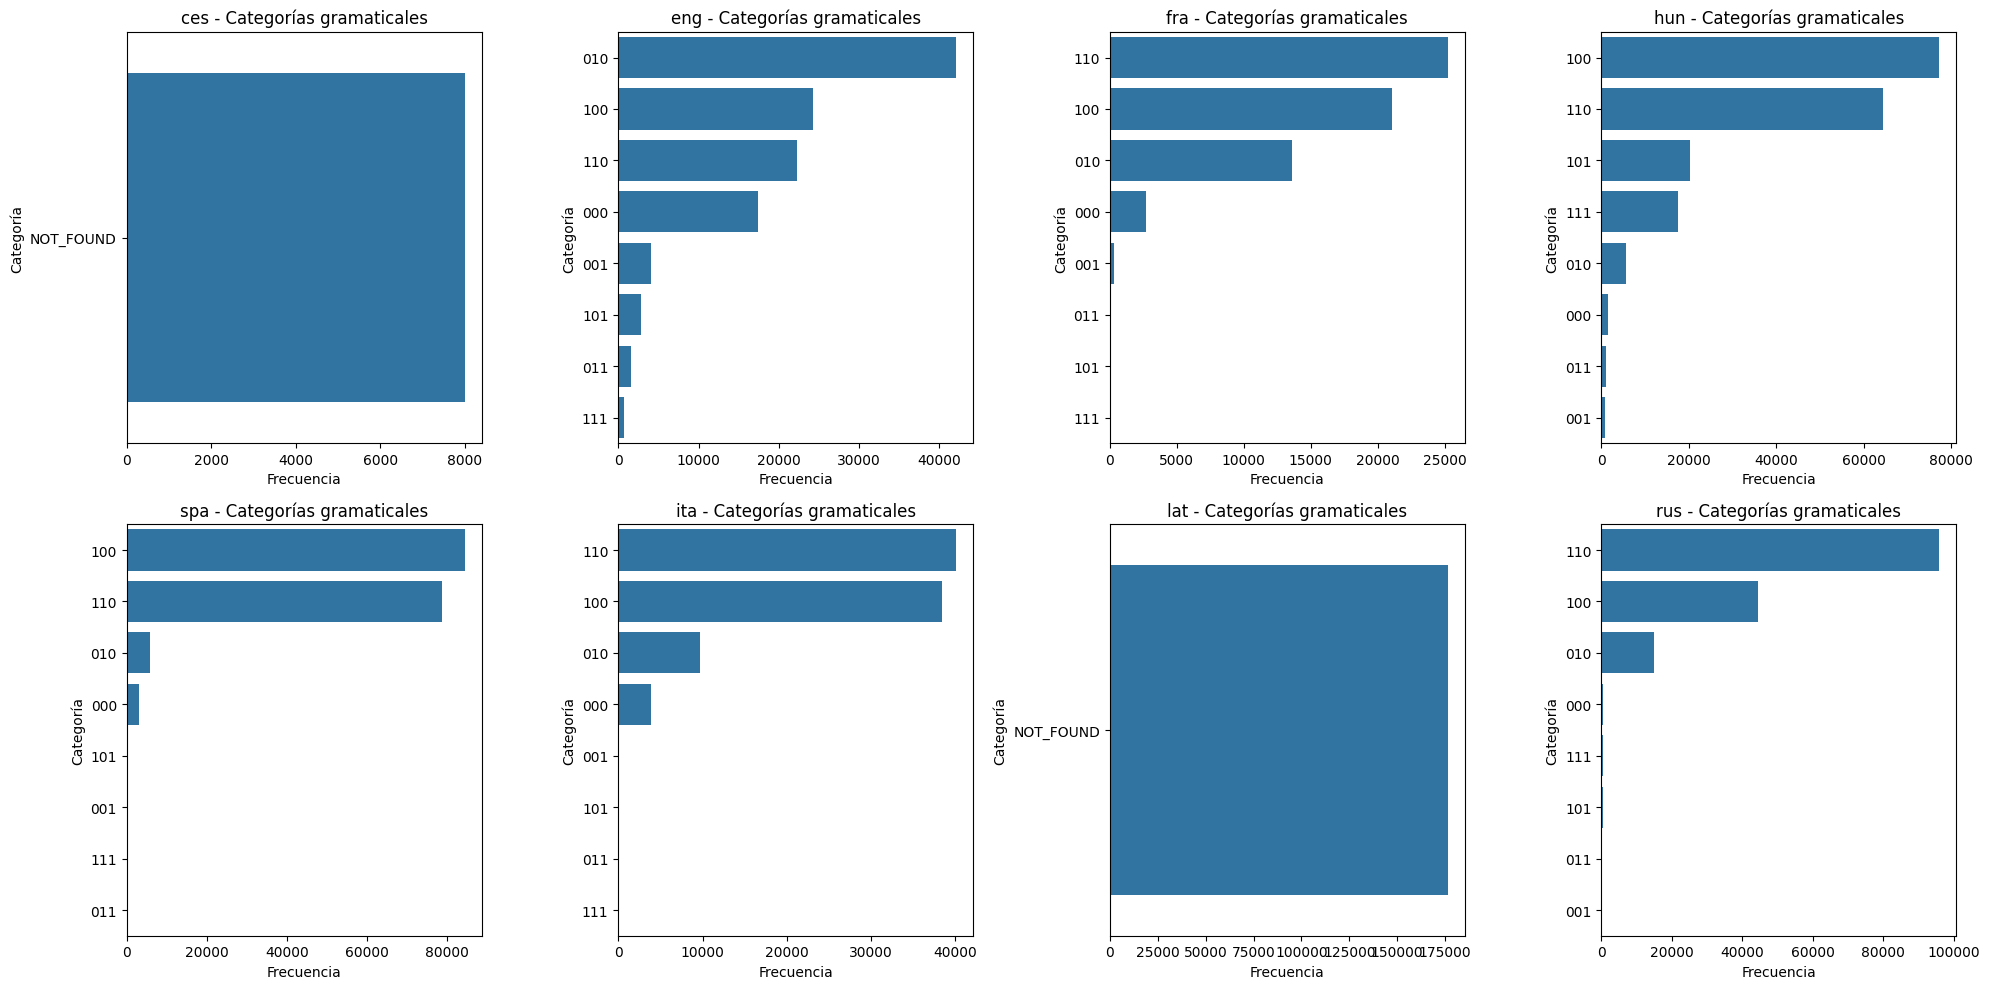

In [30]:
plot_category_distribution(data_langs)

In [31]:
def print_morphology_stats(data_dict):
    """
    Imprime estadísticas clave para cada lengua.

    Args:
        data_dict (dict): Diccionario con claves como 'lengua' y valores con DataFrames.
    """
    for lang, df in data_dict.items():
        total_words = len(df)
        avg_word_length = df['words'].apply(len).mean()
        avg_morpheme_count = df['morph_count'].mean() if 'morph_count' in df.columns else "N/A"
        most_common_category = df['category'].mode()[0] if 'category' in df.columns else "N/A"
        
        print(f"\n{lang}")
        print(f"Total de palabras: {total_words}")
        print(f"Longitud promedio de palabras: {avg_word_length:.2f}")
        print(f"Cuenta de morfemas promedio: {avg_morpheme_count}")
        print(f"Categoría más común: {most_common_category}")

print_morphology_stats(data_langs)



ces
Total de palabras: 8000
Longitud promedio de palabras: 7.84
Cuenta de morfemas promedio: 3.59075
Categoría más común: NOT_FOUND

eng
Total de palabras: 115126
Longitud promedio de palabras: 10.11
Cuenta de morfemas promedio: 2.353230373677536
Categoría más común: 010

fra
Total de palabras: 63173
Longitud promedio de palabras: 10.20
Cuenta de morfemas promedio: 2.6686400835800104
Categoría más común: 110

hun
Total de palabras: 188074
Longitud promedio de palabras: 10.86
Cuenta de morfemas promedio: 3.2302816976296564
Categoría más común: 100

spa
Total de palabras: 172173
Longitud promedio de palabras: 10.69
Cuenta de morfemas promedio: 3.236227515347935
Categoría más común: 100

ita
Total de palabras: 92304
Longitud promedio de palabras: 10.80
Cuenta de morfemas promedio: 2.682657306292252
Categoría más común: 110

lat
Total de palabras: 176467
Longitud promedio de palabras: 10.55
Cuenta de morfemas promedio: 2.4890036097400645
Categoría más común: NOT_FOUND

rus
Total de palabr

#### **Conclusión :**
- Las palabras en la mayoría de las lenguas tienen alrededor de 10 letras, excepto en checo, donde son un poco más cortas.

- El inglés es el idioma más simple en términos de morfología, ya que sus palabras tienen menos partes o modificaciones, lo que indica que depende más de palabras separadas para expresar relaciones gramaticales en lugar de afijos.

- El ruso y el húngaro destacan como lenguas altamente morfológicas, con palabras largas y más morfemas, lo que confirma su naturaleza flexiva y aglutinante respectivamente.

- El español, el italiano y el francés tienen una estructura similar, con palabras de tamaño medio y más modificaciones que el inglés, pero menos que el ruso o el húngaro.

- Las categorías más comunes en todas las lenguas analizadas parecen ser sustantivos y verbos, lo cual es lógico, ya que son las palabras más usadas en el lenguaje.

### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

#### Carga de datos y entrenamiento del etiquetador
Código reutilizado del notebook de clase

In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install -U sklearn-crfsuite

In [33]:
import nltk

# Descargando el corpus cess_esp: https://www.nltk.org/book/ch02.html#tab-corpora
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [34]:
from nltk.corpus import cess_esp
# Cargando oraciones
corpora = cess_esp.tagged_sents()

In [35]:
import requests

def get_tags_map() -> dict:
    tags_raw = requests.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")

def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    result = []
    for sentence in corpora:
        print
        result.append([(word, map_tag(tag)) for word, tag in sentence if tag not in ["Fp", "Fc", "Fpa", "Fpt"]])
    return result

In [36]:
corpora = parse_tags(corpora)

In [39]:
def word_to_features(sent, i):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prefix_1': word[:1],
        'prefix_2': word[:2],
        'suffix_1': word[-1:],
        'suffix_2': word[-2:],
        'word_len': len(word)
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

# Extract features and labels
def sent_to_features(sent) -> list:
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent) -> list:
    return [label for token, label in sent]

In [40]:
# Preparando datos para el CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpora]
y = [[pos for _, pos in sent] for sent in corpora]

In [41]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
assert len(X_train) + len(X_test) == len(corpora), "Something wrong with my split :("
assert len(y_train) + len(y_test) == len(corpora), "Something wrong with my split :("

In [43]:
from inspect import Attribute
from sklearn_crfsuite import CRF
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

loading training data to CRFsuite: 100%|██████████| 4824/4824 [00:01<00:00, 2861.65it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67684
Seconds required: 0.468

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.57  loss=296361.69 active=66733 feature_norm=0.50
Iter 2   time=0.16  loss=274496.22 active=66451 feature_norm=0.43
Iter 3   time=0.36  loss=268124.40 active=66864 feature_norm=0.50
Iter 4   time=0.29  loss=259997.04 active=67083 feature_norm=0.64
Iter 5   time=0.28  loss=229759.34 active=66884 feature_norm=1.46
Iter 6   time=0.17  loss=192769.26 active=67105 feature_norm=2.81
Iter 7   time=0.16  loss=162202.75 active=67202 feature_norm=4.47
Iter 8   time=0.15  loss=135392.33 active=67332 feature_norm=5.69
Iter 9   time=0.14  loss=114697.04 active=67160 feature_norm=7.82
Iter 

#### Evaluación y matriz de confusion

In [45]:
from sklearn.metrics import classification_report
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

           .       1.00      1.00      1.00      1035
         ADJ       0.90      0.90      0.90      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.95      0.95      1473
        CONJ       0.97      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.97      0.97      0.97      9005
         NUM       0.94      0.98      0.96       400
        PRON       0.95      0.95      0.95      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      1.00      1.00         4

    accuracy                           0.97     35091
   macro avg       0.97      0.97      0.97     35091
weighted avg       0.97      0.97      0.97     35091



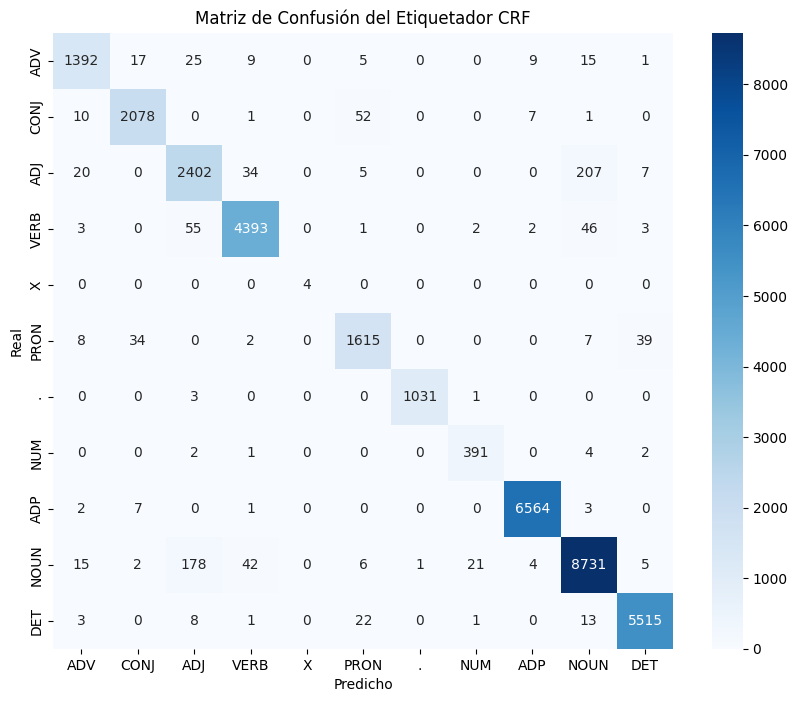

In [46]:
from sklearn.metrics import confusion_matrix

# Obtener las etiquetas únicas en y_test
labels = list(set(y_test_flat))  

# Generar la matriz de confusión
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Etiquetador CRF")
plt.show()

#### **Conclusión :**

Como vimos en clase, el modelo CRF funciona bastante bien, la mayoría de las etiquetas están correctamente clasificadas (valores altos en la diagonal de la MC).

Sin embargo, al analizar la MC podemos observar algunos errores en etiquetas que pueden tener funciones similares en ciertas oraciones:

- Los adjetivos a veces se confunden con sustantivos  y determinantes, lo cual es esperado, ya que algunas palabras pueden funcionar como ambos dependiendo del contexto.

- Los pronombres se confunden ocasionalmente con determinantes, lo que ocurre en español con palabras como "este" o "aquel", que pueden actuar como pronombres o adjetivos según su uso.

También se identifican errores menores en la clasificación de adverbios y conjunciones, así como en los números, que en algunos casos fueron etiquetados como sustantivos. 

En general, el modelo funciona bien, pero su rendimiento podría mejorar mediante el uso de características adicionales que ayuden a distinguir mejor las palabras con múltiples posibles etiquetas.